## Dylan Doyle - 10/12/25

# API Data Report

## Hypothesis - I am using the get posts and the get likes API's. I believe that Accounts with more followers recieve a higher engagement (likes and reposts)per post than accounts without. Statistically this can be tested by correlation analysis between like counts and replies and reposts. I believe that users are more likely to engage with assignments that already have lots of likes because they know a lot of other people enjoy the post and feel comfortable liking it.

## I am using app.bsky.feed.getPosts to collect post data. This fits my hypothesis because I need information on posts. I am using app.bsky.feed.getLikes to further understand like paterns to be able to understand patterns and user behavior. These will be reliable due to them being real time data. What makes this data possibly unreliable is that there could be bots or missing deleted posts. The only limitation is the limit to 100 likes per request. Also private account data can not be accessed. 

## Importing libraries and loading in API

In [69]:
import requests
import time
import json as js
import pandas as pd
from datetime import datetime
import base64

BASE_URL = "https://api.bsky.app/xrpc"
endpoint = f"{BASE_URL}/app.bsky.feed.searchPosts"
headers = {"User-Agent": "EMAT-Teaching/1.0 (+contact@example.com)"}
params = {
    "q": "news",  
    "limit": 30,
}



## Data Collection

In [70]:


resp = requests.get(endpoint, params=params, headers=headers, timeout=30)
print("Search Status:", resp.status_code)

data = resp.json()
posts_from_search = data.get("posts", [])
print(f"Number of posts found: {len(posts_from_search)}")


post_uris = [post['uri'] for post in posts_from_search]
print(f"Post URIs collected: {len(post_uris)}")


Search Status: 200
Number of posts found: 30
Post URIs collected: 30


In [42]:
all_posts_data = []
batch_size = 10

for i in range(0, len(post_uris), batch_size):
    batch_uris = post_uris[i:i + batch_size]
    
    posts_endpoint = f"{BASE_URL}/app.bsky.feed.getPosts"
    params = {"uris": batch_uris}
    
    resp = requests.get(posts_endpoint, params=params, headers=headers, timeout=30)
    
    if resp.status_code == 200:
        data = resp.json()
        posts = data.get('posts', [])
        all_posts_data.extend(posts)
        print(f"Batch {i//batch_size + 1}: Got {len(posts)} posts")
    else:
        print(f"Batch {i//batch_size + 1}: Failed with status {resp.status_code}")
        time.sleep(0.5)

        print(f"Total posts collected: {len(all_posts_data)}")

Batch 1: Got 10 posts
Batch 2: Got 10 posts
Batch 3: Got 10 posts


## Process Posts data

In [71]:
posts_rows = []
for post in all_posts_data:
    record = post.get('record', {})
    author = post.get('author', {})
    
    posts_rows.append({
        "post_uri": post.get('uri'),
        "like_count": post.get('likeCount', 0),
        "reply_count": post.get('replyCount', 0),
        "repost_count": post.get('repostCount', 0),
        "author_did": author.get('did'),
        "author_handle": author.get('handle'),
        "author_displayName": author.get('displayName'),
        "text_preview": record.get('text', '')[:50] + "...", 
    })

posts_df = pd.DataFrame(posts_rows)
print("Posts DataFrame:")
print(posts_df.head())

Posts DataFrame:
                                            post_uri  like_count  reply_count  \
0  at://did:plc:j2vin3amzye5ifg24bzqrjep/app.bsky...           1            1   
1  at://did:plc:hk4amexkrqze6zjrjpednyui/app.bsky...           0            0   
2  at://did:plc:o6ggjvnj4ze3mnrpnv5oravg/app.bsky...           0            0   
3  at://did:plc:u4pjym7nkfj3ouzlwlnxosfy/app.bsky...           0            0   
4  at://did:plc:apnawo5dla5uw2bffaynqup5/app.bsky...           1            0   

   repost_count                        author_did              author_handle  \
0             0  did:plc:j2vin3amzye5ifg24bzqrjep      nparmalee.bsky.social   
1             0  did:plc:hk4amexkrqze6zjrjpednyui      lindav138.bsky.social   
2             0  did:plc:o6ggjvnj4ze3mnrpnv5oravg              longtail.news   
3             0  did:plc:u4pjym7nkfj3ouzlwlnxosfy            fhj.bsky.social   
4             0  did:plc:apnawo5dla5uw2bffaynqup5  electronicdan.bsky.social   

  author_displa

## Getting Follower Counts

In [49]:
unique_authors = posts_df['author_did'].unique().tolist()
print(f"Getting profiles for {len(unique_authors)} unique authors")

profiles_rows = []

for author_did in unique_authors:
    try:
        profile_endpoint = f"{BASE_URL}/app.bsky.actor.getProfile"
        params = [("actor", author_did)]
        
        resp = requests.get(profile_endpoint, params=params, headers=headers, timeout=30)
        
        if resp.status_code == 200:
            profile_data = resp.json()
            profiles_rows.append({
                "author_did": profile_data.get('did'),
                "author_handle": profile_data.get('handle'),
                "followers_count": profile_data.get('followersCount', 0),
                "follows_count": profile_data.get('followsCount', 0),
                "posts_count": profile_data.get('postsCount', 0),
                "description": profile_data.get('description', '')[:100]
            })
        else:
            print(f"Failed to get profile for {author_did}: Status {resp.status_code}")

    except Exception as e:  
        print(f"Error getting profile for {author_did}: {e}")
    
    time.sleep(0.2)  

profiles_df = pd.DataFrame(profiles_rows)
print("Profiles DataFrame:")
print(profiles_df.head())


Getting profiles for 27 unique authors
Profiles DataFrame:
                         author_did              author_handle  \
0  did:plc:j2vin3amzye5ifg24bzqrjep      nparmalee.bsky.social   
1  did:plc:hk4amexkrqze6zjrjpednyui      lindav138.bsky.social   
2  did:plc:o6ggjvnj4ze3mnrpnv5oravg              longtail.news   
3  did:plc:u4pjym7nkfj3ouzlwlnxosfy            fhj.bsky.social   
4  did:plc:apnawo5dla5uw2bffaynqup5  electronicdan.bsky.social   

   followers_count  follows_count  posts_count  \
0             1208            467         2023   
1             1185            388         6169   
2             1238              4      2443862   
3             4276           7909         1497   
4             1830           1710          930   

                                         description  
0  Human geneticist turned data scientist in Seat...  
1  A lifelong socialist who is looking for a spar...  
2  Custom feeds made up of articles from less com...  
3  I am a person who st

## Detailed Likes for analysis

In [72]:
if not profiles_df.empty and not posts_df.empty:

    temp_merge = posts_df.merge(profiles_df, on='author_did', how='left')
    high_follower_posts = temp_merge.nlargest(2, 'followers_count')['post_uri'].tolist()
    low_follower_posts = temp_merge.nsmallest(2, 'followers_count')['post_uri'].tolist()
    selected_posts = high_follower_posts + low_follower_posts
    
    print(f"Selected {len(selected_posts)} posts for like analysis")

Selected 4 posts for like analysis


In [51]:
likes_rows = []
for post_uri in selected_posts:
    likes_endpoint = f"{BASE_URL}/app.bsky.feed.getLikes"
    params = {
        "uri": post_uri,
        "limit": 20
    }
    

In [67]:
likes_rows = []

for post_uri in selected_posts:
    likes_endpoint = f"{BASE_URL}/app.bsky.feed.getLikes"
    params = {"uri": post_uri, "limit": 100}
    
    try:
        resp = requests.get(likes_endpoint, params=params, headers=headers, timeout=30)
        
        if resp.status_code == 200:
            likes_data = resp.json()
            likes = likes_data.get('likes', [])
            
            for like in likes:
                likes_rows.append({
                    "post_uri": post_uri,
                    "liker_handle": like.get('actor', {}).get('handle'),
                    "liked_at": like.get('createdAt')
                })
            
            print(f"Post {post_uri[:30]}...: {len(likes)} likes")
        else:
            print(f"Failed for {post_uri[:30]}...: Status {resp.status_code}")
    
    except Exception as e:
        print(f"Error getting likes for {post_uri[:30]}...: {e}")
    
    time.sleep(0.5) 

likes_df = pd.DataFrame(likes_rows)
print(f"Total detailed likes collected: {len(likes_df)}")
print(likes_df.head())


Post at://did:plc:2buz4gf5sew3rdwzb...: 43 likes
Post at://did:plc:yosojsta3nm5qiod5...: 47 likes
Post at://did:plc:zcwlvbsrp6agrazym...: 7 likes
Post at://did:plc:vp2ksrmu6lj5tdpmj...: 0 likes
Total detailed likes collected: 97
                                            post_uri  \
0  at://did:plc:2buz4gf5sew3rdwzbxsvcd4s/app.bsky...   
1  at://did:plc:2buz4gf5sew3rdwzbxsvcd4s/app.bsky...   
2  at://did:plc:2buz4gf5sew3rdwzbxsvcd4s/app.bsky...   
3  at://did:plc:2buz4gf5sew3rdwzbxsvcd4s/app.bsky...   
4  at://did:plc:2buz4gf5sew3rdwzbxsvcd4s/app.bsky...   

                 liker_handle                  liked_at  
0     laddermatch.bsky.social  2025-10-12T23:46:49.350Z  
1  glitterburrito.bsky.social  2025-10-12T23:46:22.051Z  
2        goahtani.bsky.social  2025-10-12T23:42:07.383Z  
3             theadamzone.xyz  2025-10-12T23:41:47.345Z  
4   joshuadaulton.bsky.social  2025-10-12T23:37:30.439Z  


## Combining Data and Analysis

In [60]:
final_df = posts_df.merge(
    profiles_df,
    on='author_did',
    how='left'
)

print(f"Final combined DataFrame shape: {final_df.shape}")

Final combined DataFrame shape: (30, 13)


## Engagement Metrics

In [68]:
final_df['total_engagement'] = final_df['like_count'] + final_df['repost_count'] + final_df['reply_count']
final_df['engagement_rate'] = final_df['total_engagement'] / final_df['followers_count'].replace(0, 1) 

print("\nBasic Statistics:")
print(f"Average followers per account: {final_df['followers_count'].mean():.0f}")
print(f"Average likes per post: {final_df['like_count'].mean():.2f}")
print(f"Average reposts per post: {final_df['repost_count'].mean():.2f}")
print(f"Average total engagement: {final_df['total_engagement'].mean():.2f}")


Basic Statistics:
Average followers per account: 19249
Average likes per post: 0.77
Average reposts per post: 0.13
Average total engagement: 0.93


## Correlation Analysis

In [62]:
correlation_followers_likes = final_df['followers_count'].corr(final_df['like_count'])
correlation_followers_reposts = final_df['followers_count'].corr(final_df['repost_count'])
correlation_followers_engagement = final_df['followers_count'].corr(final_df['total_engagement'])

print(f"\nCorrelation Analysis:")
print(f"Followers vs Likes: {correlation_followers_likes:.3f}")
print(f"Followers vs Reposts: {correlation_followers_reposts:.3f}")
print(f"Followers vs Total Engagement: {correlation_followers_engagement:.3f}")


Correlation Analysis:
Followers vs Likes: 0.741
Followers vs Reposts: 0.362
Followers vs Total Engagement: 0.695


## Comparison Categories

In [64]:
final_df['follower_category'] = pd.cut(
    final_df['followers_count'],
    bins=[0, 1000, 10000, float('inf')],
    labels=['Small (<1k)', 'Medium (1k-10k)', 'Large (>10k)']
)

engagement_by_category = final_df.groupby('follower_category').agg({
    'like_count': 'mean',
    'repost_count': 'mean',
    'total_engagement': 'mean',
    'engagement_rate': 'mean'
}).round(2)

print("\nEngagement by Follower Category:")
print(engagement_by_category)


Engagement by Follower Category:
                   like_count  repost_count  total_engagement  engagement_rate
follower_category                                                             
Small (<1k)              0.38          0.00              0.38             0.05
Medium (1k-10k)          0.27          0.13              0.47             0.00
Large (>10k)             7.00          1.00              8.00             0.00


/var/folders/m3/y8lj06jd1jnby6zyttfn2p1m0000gn/T/ipykernel_44239/687252024.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_by_category = final_df.groupby('follower_category').agg({


# Visualizations for Hypothesis Testing
Followers V Likes 

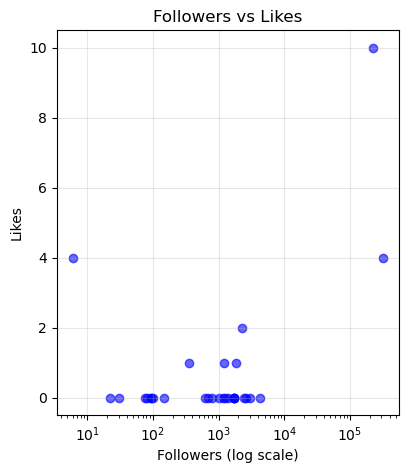

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))


plt.subplot(1, 3, 1)
plt.scatter(final_df['followers_count'], final_df['like_count'], alpha=0.6, color='blue')
plt.xscale('log')  
plt.xlabel('Followers (log scale)')
plt.ylabel('Likes')
plt.title('Followers vs Likes')
plt.grid(True, alpha=0.3)


## Followers V Reposts

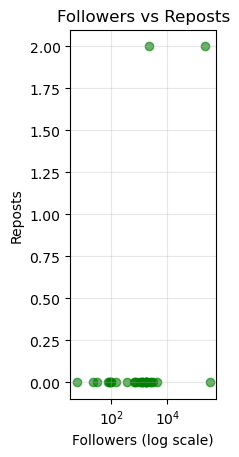

In [66]:
plt.subplot(1, 3, 2)
plt.scatter(final_df['followers_count'], final_df['repost_count'], alpha=0.6, color='green')
plt.xscale('log')
plt.xlabel('Followers (log scale)')
plt.ylabel('Reposts')
plt.title('Followers vs Reposts')
plt.grid(True, alpha=0.3)

## Hypothesis Results
I found that there is a slight positive correlation between follower count and engagement of posts. Based on my visuals, its clear as I assumed in my hypothesis that likes go up based on your follower count. Reposts don't show it as clear in the visualization but it still does increase based on followers. I faced many challenges during this, I ended up having to restart 3 different times. My main problem was the limited sampling size and properly creating variables that would work best for me.